# Dependencies

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing import image
import warnings
from PIL import Image

#Torch

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, utils
from torchvision.transforms import ToTensor, v2
from torchvision.io import read_image
#Torch model
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torch.optim as optim
import time

# if os.getenv("COLAB_RELEASE_TAG"):
#   !pip install timm
#   import timm

import gdown
import zipfile
from tqdm import tqdm

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING=1

# Data Processing



### Upload data to colab

In [ ]:
if not os.path.exists("wb_recognition_dataset.zip"):
    !gdown --id 1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh
else:
    print("File already exists, skipping download.")

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh
From (redirected): https://drive.google.com/uc?id=1PdWkZe8Vt6xdsTj8KeqxhAd5Tmx4pyNh&confirm=t&uuid=1c60567b-a2e6-4dab-a63d-69a77c6998eb
To: /content/wb_recognition_dataset.zip
100% 105M/105M [00:00<00:00, 164MB/s] 


In [ ]:
if not os.path.exists("wb_recognition_dataset"):
    with zipfile.ZipFile("wb_recognition_dataset.zip", "r") as zip_ref:
        zip_ref.extractall("wb_recognition_dataset")

In [ ]:
local_dir = 'wb_recognition_dataset'
colab_dir = '/content/wb_recognition_dataset/wb_recognition_dataset'

In [ ]:
dataset_dir = f'{colab_dir}'
trainset_dir = f'{dataset_dir}/train'
testset_dir = f'{dataset_dir}/val'
testset_img = f'{testset_dir}/images'
annotations_dir = f'{testset_dir}/labels.csv'

In [ ]:
print('Number of classes in the train dataset:', len(os.listdir(trainset_dir)))
print('Number of images in the valid dataset:', len(os.listdir(testset_img)))

Number of classes in the train dataset: 2130
Number of images in the valid dataset: 1392


In [ ]:
# num_folders = 2139  # Assuming the range is from 0 to 2138

# # Create missing folders
# for i in range(num_folders):
#     folder_path = os.path.join(trainset_dir, str(i))
#     if not os.path.exists(folder_path):
#         os.makedirs(folder_path)

In [ ]:
print('Number of classes in the train dataset:', len(os.listdir(trainset_dir)))

Number of classes in the train dataset: 2130


In [ ]:
# Iterate over directories
for folder in os.listdir(trainset_dir):
    folder_path = os.path.join(trainset_dir, folder)
    if os.path.isdir(folder_path) and not os.listdir(folder_path):
        print(folder_path)

### Data Pre-processing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),  # Convert image to tensor
])


In [ ]:
# get all the full image dirs in each folder
data = [
    (os.path.join(trainset_dir, c, f), int(c))
    for c in os.listdir(trainset_dir)
    if os.path.isdir(os.path.join(trainset_dir, c)) and any(os.listdir(os.path.join(trainset_dir, c)))
    for f in os.listdir(os.path.join(trainset_dir, c))
]
print(data[0])

('/content/wb_recognition_dataset/wb_recognition_dataset/train/1664/43_1664.png', 1664)


In [ ]:
main_df = pd.DataFrame(data, columns = ['image', 'label'])
main_df

,image,label
0,/content/wb_recognition_dataset/wb_recognition...,1664
1,/content/wb_recognition_dataset/wb_recognition...,1664
2,/content/wb_recognition_dataset/wb_recognition...,1664
3,/content/wb_recognition_dataset/wb_recognition...,1664
4,/content/wb_recognition_dataset/wb_recognition...,1664
...,...,...
56808,/content/wb_recognition_dataset/wb_recognition...,342
56809,/content/wb_recognition_dataset/wb_recognition...,342
56810,/content/wb_recognition_dataset/wb_recognition...,342
56811,/content/wb_recognition_dataset/wb_recognition...,342


In [ ]:
main_df['label'].max()

2138

In [ ]:
main_df = pd.DataFrame(data, columns = ['image', 'label'])
# main_df = encoding(main_df)
main_df

,image,label
0,/content/wb_recognition_dataset/wb_recognition...,1218
1,/content/wb_recognition_dataset/wb_recognition...,1218
2,/content/wb_recognition_dataset/wb_recognition...,1218
3,/content/wb_recognition_dataset/wb_recognition...,1218
4,/content/wb_recognition_dataset/wb_recognition...,1218
...,...,...
56808,/content/wb_recognition_dataset/wb_recognition...,402
56809,/content/wb_recognition_dataset/wb_recognition...,402
56810,/content/wb_recognition_dataset/wb_recognition...,402
56811,/content/wb_recognition_dataset/wb_recognition...,402


In [ ]:
# # check if all rows only have at maximum of 1 class
# assert main_df.iloc[:, 1:].sum(axis=1).max() == 1

In [ ]:
# find the label of an image
for c in main_df.columns[1:]:
    if main_df[c].iloc[1] == 1: # change the index to find the label of another image, just for testing
        print(c)

In [ ]:
valid_label = pd.read_csv(annotations_dir)
valid_label.iloc[0][1]

10

In [ ]:
valid_data = [
    (os.path.join(testset_img, str(valid_label.iloc[i, 0])+ ".jpg"), int(valid_label.iloc[i, 1]))
    for i in range(valid_label.shape[0])
]

In [ ]:
val_df = pd.DataFrame(valid_data, columns = ['image', 'label'])
# val_df = encoding(val_df)
val_df

,image,label
0,/content/wb_recognition_dataset/wb_recognition...,10
1,/content/wb_recognition_dataset/wb_recognition...,1001
2,/content/wb_recognition_dataset/wb_recognition...,1004
3,/content/wb_recognition_dataset/wb_recognition...,1004
4,/content/wb_recognition_dataset/wb_recognition...,1004
...,...,...
1387,/content/wb_recognition_dataset/wb_recognition...,1549
1388,/content/wb_recognition_dataset/wb_recognition...,155
1389,/content/wb_recognition_dataset/wb_recognition...,1551
1390,/content/wb_recognition_dataset/wb_recognition...,1553


In [ ]:
def process_img(img_path: str, width=64, height=64):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # result = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    result = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 19, 17)
    result = cv2.resize(result, (width, height))

    """
    Improve if possible
    """
    result = Image.fromarray(result).convert('RGB')

    return result

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = df.iloc[:, 1].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 0]
        img = process_img(img_path=img_path)
        img_tensor = self.transform(img)
        # label = torch.tensor(self.labels[idx], dtype=torch.float32)
        label = self.labels[idx]
        return img_tensor, label

In [ ]:
trainset = CustomDataset(main_df, transform=transform)
validset = CustomDataset(val_df, transform=transform)

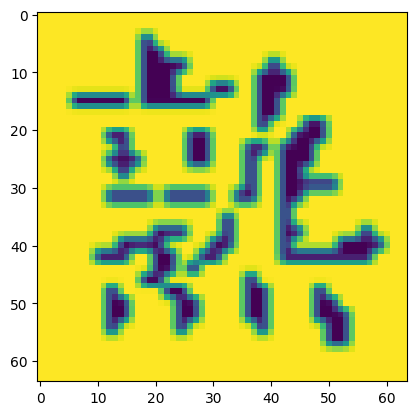

10


In [ ]:
# see a sample image, plot it
img, label = validset[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(label)
# print ((label == 2).nonzero(as_tuple=True)[0])

### Weight Distribute

In [ ]:
# class_weight = []
# sampler_weight = [0] * len(trainset)

# for c in os.listdir(trainset_dir):
#     num_files = len(os.listdir(os.path.join(trainset_dir, c)))
#     if(num_files > 0):
#         class_weight.append(1/num_files)
#     else:
#         print(c)
#         class_weight.append(1/0.01)

# for i, (img, label) in enumerate(trainset):
#     x = class_weight[label]
#     sampler_weight[i] = x

# print("Done")
# sampler_weight = WeightedRandomSampler(sampler_weight, num_samples=len(sampler_weight), replacement=True)

### DataLoader


In [ ]:
batch_size = 64
# train_loader = DataLoader(trainset,batch_size=batch_size, sampler= sampler_weight)
train_loader = DataLoader(trainset,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)

# Model

### Model Architecture

In [ ]:
class M6X(nn.Module):
    def __init__(self, classes_num):
        super(M6X, self).__init__()

        1,64,64

        # Define the layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=1, padding=5) 64,64,64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 64,32,32

        64,32,32

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=3) 128,32,32
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 128, 16,16

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2) 256,16,16
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) 256,8,8

        # self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        # self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256*8*8, 1024)
        # self.drop1 = nn.Dropout(0.25)
        # self.fc2 = nn.Linear(1024, 1024)+

        self.drop2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(1024, classes_num)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Forward pass
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        # x = self.pool4(self.relu(self.conv4(x)))
        x = x.view(-1, 256*8*8)
        x = self.relu(self.fc1(x))
        # x = self.drop1(x)
        # x = self.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x

### Initiate Model

Note: Change the input data transform fuction accordingly to the chosen model


In [ ]:
#Change the id to the wanted checkpoint_drive
!gdown --id 1Ss0YEGTAGmqVHUCqChJ4fcZvtepuAAvH

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Ss0YEGTAGmqVHUCqChJ4fcZvtepuAAvH
From (redirected): https://drive.google.com/uc?id=1Ss0YEGTAGmqVHUCqChJ4fcZvtepuAAvH&confirm=t&uuid=7b88ebc8-aa59-4da3-a6d5-d2e7d49f5f0c
To: /content/M6_test_checkpoint.pth
100% 242M/242M [00:08<00:00, 29.0MB/s]


In [ ]:
M6X_checkpoint_path = "/content/M6_test_checkpoint.pth"

In [ ]:
outdim = 2139

In [ ]:
model = M6X(outdim)

In [ ]:
current_epoch = 0

if (os.path.isfile(M6X_checkpoint_path)):
    loaded_checkpoint = torch.load(M6X_checkpoint_path)
    model.load_state_dict(loaded_checkpoint['model_state'])
    current_epoch = loaded_checkpoint['epochs'] + current_epoch
    print(f'Load model from checkpoint| Epoch: {current_epoch}')

Load model from checkpoint| Epoch: 2


# Traning



### Parameter

In [ ]:

leaning_rate = 1e-3 #0,01
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=leaning_rate)
# optimizer = optim.SGD(model.parameters(), lr=leaning_rate)

In [ ]:
model.to(device);

In [ ]:
model

M6X(
  (conv1): Conv2d(1, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (drop2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=1024, out_features=2139, bias=True)
  (relu): ReLU()
)

### Traning Loop

In [ ]:
def train(epoch):
    step_loss = []
    model.train()
    correct = 0

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        step_loss.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    accuracy = correct / len(train_loader.dataset)

    print(f"Epoch: {epoch}, Loss: {loss.item()}, Acc: {accuracy}" )

    return step_loss

In [ ]:
def valid():
    step_loss = []
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in tqdm(val_loader):
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss += criterion(output, y).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()
            step_loss.append(criterion(output, y).item())

    loss /= len(val_loader.dataset)
    accuracy = correct / len(val_loader.dataset)

    return loss, accuracy, step_loss

In [ ]:
epochs = 2
trainingEpoch_loss = []
validationEpoch_loss = []

for epoch in range(epochs):
    train_loss = train(epoch)
    trainingEpoch_loss.append(np.array(train_loss).mean())

    loss, accuracy, val_loss = valid()
    print(loss, accuracy)
    validationEpoch_loss.append(np.array(val_loss).mean())

100%|██████████| 888/888 [01:15<00:00, 11.74it/s]


Epoch: 0, Loss: 1.6316055059432983, Acc: 0.5075774910671853


100%|██████████| 22/22 [00:00<00:00, 24.80it/s]


0.028620119495638485 0.694683908045977


  4%|▎         | 33/888 [00:02<01:10, 12.19it/s]


KeyboardInterrupt: 

In [ ]:
checkpoint = {
    "epochs": current_epoch + epochs,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict()
}

torch.save(checkpoint, M6X_checkpoint_path)

In [ ]:
print(valid())

100%|██████████| 22/22 [00:01<00:00, 20.14it/s]

(0.029820638569607132, 0.7076149425287356, [1.9680689573287964, 1.0593329668045044, 1.9348819255828857, 2.4505906105041504, 1.0369333028793335, 1.4410958290100098, 1.3475879430770874, 2.2092628479003906, 1.307507038116455, 2.4285824298858643, 1.9156380891799927, 1.9937231540679932, 1.9986624717712402, 2.033358335494995, 1.4805450439453125, 1.48367178440094, 2.4155030250549316, 1.9174772500991821, 2.127544403076172, 2.3680686950683594, 1.1888206005096436, 3.4034721851348877])


### Analyze
1 graph -> Epoch | Loss

In [ ]:
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.title("Loss curve")
plt.legend()
plt.show